In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='452778eb-d85f-4567-a2ee-ae3cf613c834', project_access_token='')
pc = project.project_context


# Predicting Athletes' Success based on Physical Built - Initial Data Exploration

In [2]:
# Setting seed for reproducability
SEED = 42

# Numpy
import numpy as np
np.random.seed(SEED)

# Pandas
import pandas as pd

# Vizualization
import seaborn as sns
sns.set(style="whitegrid")

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Dataset
This dataset is asic bio data on athletes and medal results from Athens 1896 to Rio 2016. 
https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results

In [3]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_ae9960ddc8814d4c8b5407d633c117e6 = 'https://s3.ap.cloud-object-storage.appdomain.cloud'
else:
    endpoint_ae9960ddc8814d4c8b5407d633c117e6 = 'https://s3.private.ap.cloud-object-storage.appdomain.cloud'

client_ae9960ddc8814d4c8b5407d633c117e6 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='y-i7Ll-_fH7OmwBZU47jYLDcYfCQFgbdSFfHOig9oGAC',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_ae9960ddc8814d4c8b5407d633c117e6)

body = client_ae9960ddc8814d4c8b5407d633c117e6.get_object(Bucket='ibmadvanceddatasciencecapstone-donotdelete-pr-imkca0ueactk84',Key='athlete_events.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [4]:
df_data_1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


In [5]:
len(df_data_1['ID'].unique())

135571

### Problem definition

As a goal of this project, I want to make prediction on the sport event of an athlete  based on the height, weight, sex, age, team, year. 

First of all, to study them we need to drop columns with incomplete data.

In [6]:
df = df_data_1.dropna(subset=["Age", "Height", "Weight"])

len(df['ID'].unique())

99088

### Target selection
Medal is chosen as the target.


### Target encoding
Now, we need to change the NAs to 0 and change our target to Medal/No Medal. Let's take a look at its values:

In [7]:
df["Medal"].value_counts()

Gold      10167
Bronze    10148
Silver     9866
Name: Medal, dtype: int64

Ok, so all we have to do is sum up the athlets with medals and then change strings to int:

In [8]:
df["Medal"] = df["Medal"].replace(np.nan, 0)
df["Medal"] = df["Medal"].map({
     0: 0,
    'Gold': 1,
    'Bronze': 1,
    'Silver': 1
})
df["Medal"].value_counts()

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0    175984
1     30181
Name: Medal, dtype: int64

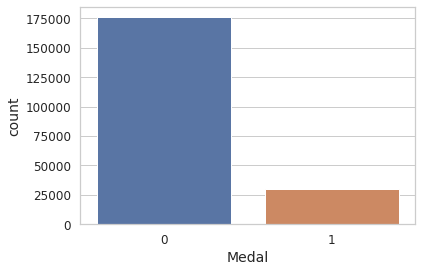

In [9]:
ax = sns.countplot(df["Medal"], label="Medal")

### Identify quality issues

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206165 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      206165 non-null  int64  
 1   Name    206165 non-null  object 
 2   Sex     206165 non-null  object 
 3   Age     206165 non-null  float64
 4   Height  206165 non-null  float64
 5   Weight  206165 non-null  float64
 6   Team    206165 non-null  object 
 7   NOC     206165 non-null  object 
 8   Games   206165 non-null  object 
 9   Year    206165 non-null  int64  
 10  Season  206165 non-null  object 
 11  City    206165 non-null  object 
 12  Sport   206165 non-null  object 
 13  Event   206165 non-null  object 
 14  Medal   206165 non-null  int64  
dtypes: float64(3), int64(3), object(9)
memory usage: 35.2+ MB


There are a lot of missing values in the Age, Height, Weight.

### Assess feature quality
This part is continued in the ETL notebook

### Get an idea on the value distribution of your data using statistical measures and visualizations


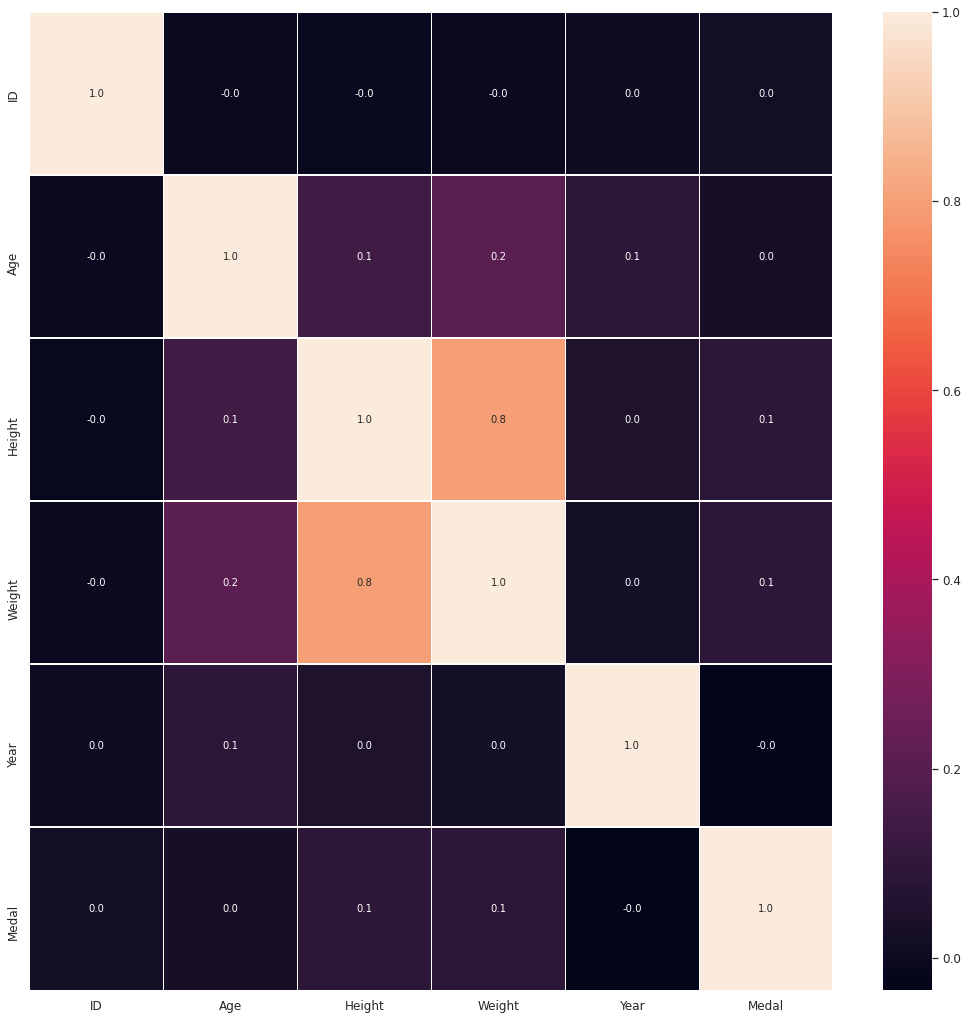

In [11]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

It seems the crrelarion between variables are not particularly strong individually. We shall see if this is true when events teams, and sexes are taken into account.  

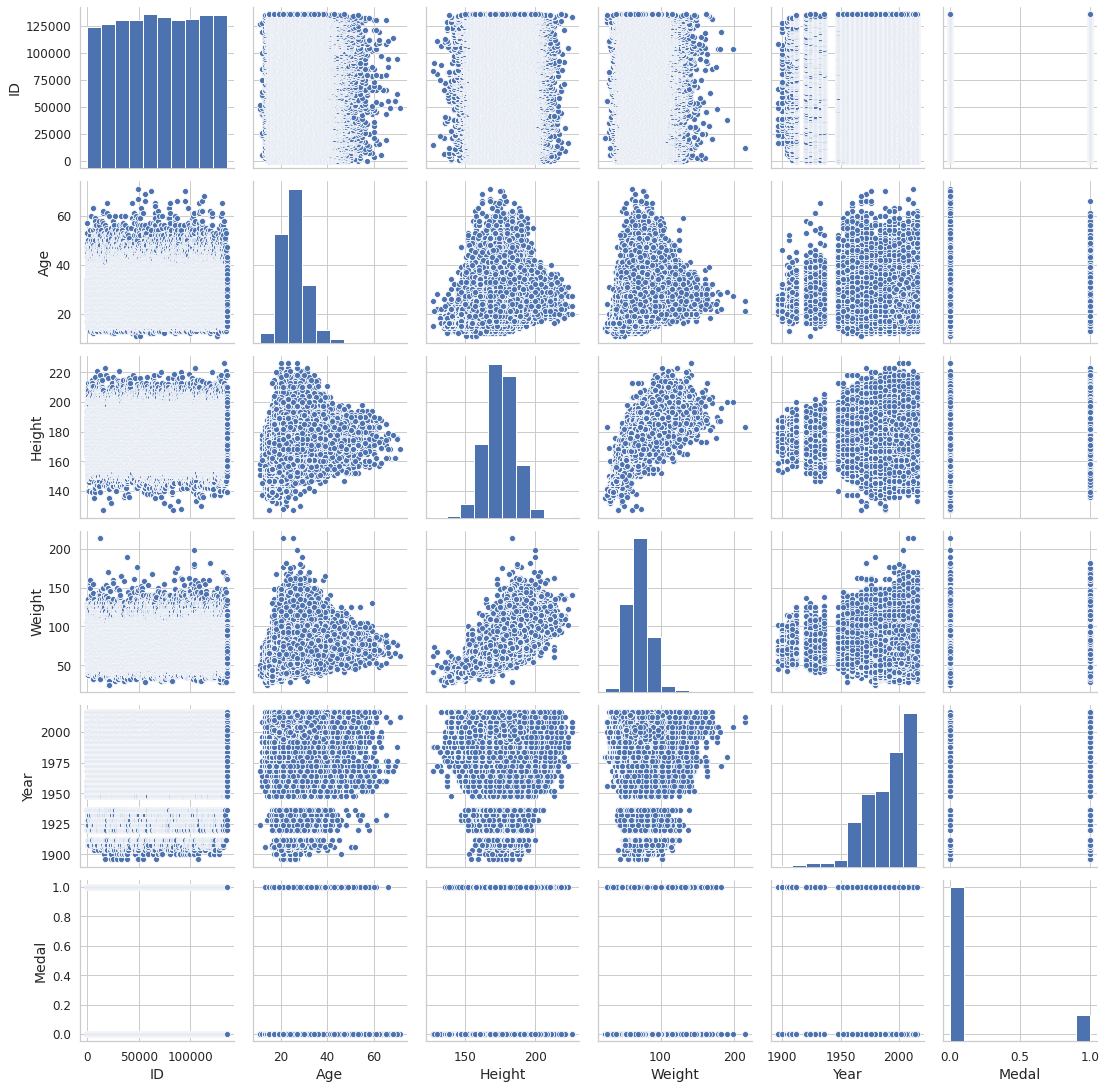

In [12]:
sns.pairplot(df, dropna=True)

### Data upload

In [13]:
project.save_data(data=df.to_csv(index=False),file_name='ide.csv',overwrite=True)

{'file_name': 'ide.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmadvanceddatasciencecapstone-donotdelete-pr-imkca0ueactk84',
 'asset_id': '85b8501d-a9a3-405e-b4af-f0b8d418d17e'}